<a href="https://colab.research.google.com/github/gauravreddy08/pytorch-vision-transformer/blob/main/vit-replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replicating **Vision Transformer** using **PyTorch**

<img src="https://raw.githubusercontent.com/gauravreddy08/pytorch-vision-transformer/main/assets/architecture.png" alt="Architecture " width="550">

> **Vision Transformer Paper:** [**An image is worth 16x16 words**](https://arxiv.org/abs/2010.11929)

> **Original Transformer Paper:** [**Attention is all you need**](https://arxiv.org/abs/1706.03762)



In [2]:
!pip install -q torchinfo wandb

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wandb

import torch
from torch import nn
import torchvision
from torchinfo import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

def set_seed(seed: int = 42):
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)

Device: cuda


In [4]:
# Self Made helper_functions to ease our model development and training process
# Visit : https://github.com/gauravreddy08/learning-pytorch/tree/main/going_modular

!git clone https://github.com/gauravreddy08/learning-pytorch
!mv /content/learning-pytorch/going_modular .
!rm -rf learning-pytorch

Cloning into 'learning-pytorch'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 59 (delta 23), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (59/59), 1.77 MiB | 3.58 MiB/s, done.


In [5]:
# Initiating WandB project 
run = wandb.init(project="vit-replication")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Downloading the **dataset**

> **Source:** [`github.com/mrdbourke/pytorch-deep-learning/pizza_steak_sushi.zip`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip)

In [6]:
import os
import zipfile

from pathlib import Path
import requests

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    data = Path("data/")
    data_path = data /destination
    if(data_path.is_dir()):
      print("[INFO] Data already exists...")
    else:
      print(f"[INFO] Did not find {data_path} directory, creating one...")
      data_path.mkdir(parents=True, exist_ok=True)

      target_file = Path(source).name
      with open(data/target_file, 'wb') as f:
        request = requests.get(source)
        print(f"[INFO] Downloading {target_file} from {source}...")
        f.write(request.content)
      with zipfile.ZipFile(data/target_file, 'r') as zip_ref:
        print(f"[INFO] Unzipping {target_file} data...")
        zip_ref.extractall(data_path)
      if remove_source:
        os.remove(data/target_file)

    return data_path

data_path = download_data("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", 
                          destination='pizaa_steak_sushi')

train_dir = data_path/'train'
test_dir = data_path/'test'

print(f"Training Directory: {train_dir}")
print(f"Testing Directory: {test_dir}")

[INFO] Did not find data/pizaa_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...
Training Directory: data/pizaa_steak_sushi/train
Testing Directory: data/pizaa_steak_sushi/test


## Turning **data** into **dataloaders**

In [7]:
from torchvision import transforms

IMG_SIZE = (224, 224) # Table 3
BATCH_SIZE = 32 # paper used 4096, we don't have computation power

# Creating transforms
manual_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)

In [8]:
from going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataset(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms)

In [9]:
imgs, labels = next(iter(train_dataloader))
image, label = imgs[0], labels[0]

print(f"Image Shape: {image.shape}")
print(f"Example Label: {label}")

Image Shape: torch.Size([3, 224, 224])
Example Label: 1


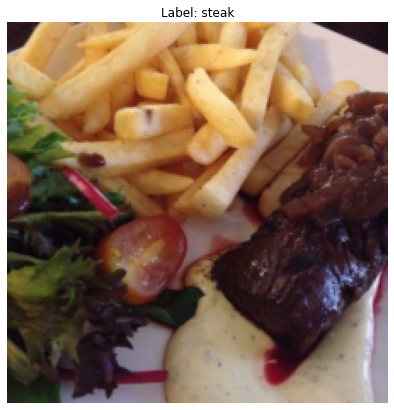

In [10]:
plt.figure(figsize=(7, 7))

plt.imshow(image.permute(1, 2, 0))
plt.title(f"Label: {class_names[label]}")
plt.axis('off');

## Building the **ViT** Model 

### **Part I: Input to our Architecture**

<img src="https://raw.githubusercontent.com/gauravreddy08/pytorch-vision-transformer/main/assets/architecture.png" alt="Architecture " width="550">

#### **Decoding the Architecture:** 
The **ViT architecture** is heavily inspired by the Transformer architecture (hence the name **"Vision Transformer"**). Instead of looking at the data as a whole, these networks focus and give "attention" to specific parts of data or an image, in our case. In a **Vision Transformer (ViT)**, the input image is first divided into smaller patches, and each patch is treated like a word in a sentence. The patches are then processed by a *transformer encoder* that's been adapted for image analysis.

So as an initial input through our network, images are resized and cropped into several different **patches**. These patches are then passed through the *transformer encoder* as **1D Tensors**. Also, each patch (image) is coupled with its respective **"positional embedding"**. And there's an extra learnable **"classification token [CLS]"** prepended in the sequence of embeddings.

> **What should be the target size of the input image?**
> 
> The target size of the input image should be 224x224. 
> > Refer table [4](https://arxiv.org/pdf/2010.11929.pdf#page=5).

> **What number of patches are extracted from a image? `3x3`? `5x5`? `10x10`?**
>
> The Base-ViT model, also commonly known as ViT16, utilizes 16x16 sized patches resulting in a total of 196 patches. 
> > Refer page [5](https://arxiv.org/pdf/2010.11929.pdf#page=5). 
``` 
 14 * 14 = 196 + 1 (CLS token) = 197
```

> **What should the dimension of the then transformed 1D Tensors be?**
> 
> The dimension of the transformed 1D Tensors should be 768. Not so coincidentally, when a patch image (3 x 16 x 16) is flattened and reshaped into a 1D tensor, we end up with a 768 dimension tensor.
>
> ```python
> [16 x 16 x 3] -> nn.Flatten() -> [1 x 768]
> ```
>
> > Refer Table [1](https://arxiv.org/pdf/2010.11929.pdf#page=5).

> **What exact layers are used to generate the image embeddings?**
>
> ViT uses **Conv2D layers** for both generating embeddings while also dividing the input image into patches. 
>
> You may ask, how can we *patchify* the image using conv layers ? 
>
> The Conv2D layers patchify the image using kernel size and stride. Specifically, setting the `kernel_size` and `stride` to 16, we can parse over the image as 16 by 16 blocks and generate the embeddings. More about this can be found in the code.

> **What's the extra learnable "classification token" mentioned?**
>
> The **Class Token** is randomly initialized and doesn’t contain any useful information on its own. However, the **Class Token** accumulates information from the other tokens in the sequence the deeper and more layers the Transformer is. 

> When the Vision Transformer finally performs the final classification of the sequence, it uses an MLP head which only looks at data from the last layer’s Class Token and no other information. [`source`](https://deepganteam.medium.com/vision-transformers-for-computer-vision-9f70418fe41a)

> **What's a positional embedding?**
> 
> The position of a patch relative to the whole image proves to be crucial information. For example, the whitespace in "the rapist" and "therapist." Transformers, unlike LSTMs, take inputs in parallel and all at once, which means they lose information about the sequence of these patches. To avoid this, we couple each image embedding with its respective positional embedding. [`source`](https://www.youtube.com/watch?v=dichIcUZfOw&ab_channel=HeduAI)


$$\mathbf{z}_0=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, \quad \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D} $$

Equation 1 pretty much sums up the whole above content into a mathematical form. 

But, how about a psuedo code ? 

**Equation 1 Psuedo Code :**
```python
x_input = [class_token, patch_1, patch_2, ..., patch_N] + [pos_0, pos_1, pos_2, ..., pos_N]

```

In [11]:
width = 224
height = 224
channels = 3

patch_size = 16
patch_count = int((width*height)/(patch_size**2))
print(f"Number of Patches (N) = {patch_count}")

Number of Patches (N) = 196


Interesting... The number of patches in a **224 x 224** image is **196**.

Now let's convert them into a 1D Tensors.

In [12]:
dummy_patch = torch.randn(patch_count, 16, 16, 3)
dummy_patch.shape

torch.Size([196, 16, 16, 3])

In [13]:
final_one_d_tensor = nn.Flatten()(dummy_patch)
print(f"Final 1D Tensors Size: {final_one_d_tensor.shape} -> (number of patches, embedding size)")

Final 1D Tensors Size: torch.Size([196, 768]) -> (number of patches, embedding size)


### Visualising a **image** as **patches**

In [14]:
image_permuted = image.permute(1, 2, 0)
image_permuted.shape

torch.Size([224, 224, 3])

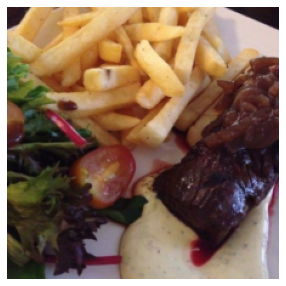

In [15]:
plt.figure(figsize=(5, 5))
plt.imshow(image_permuted)
plt.axis('off');

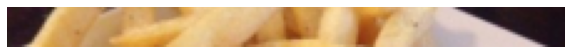

In [16]:
plt.figure(figsize=(10, 2))
plt.imshow(image_permuted[:patch_size, :, :])
plt.axis('off');

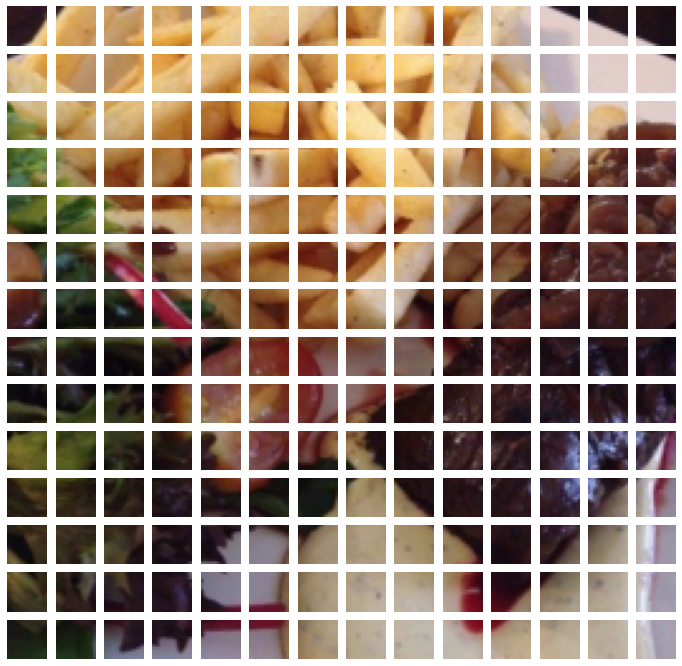

In [17]:
img_size = 224

fig, axs = plt.subplots(224//patch_size, 224//patch_size, 
                        figsize = (12, 12), sharex=True, sharey=True)
for j, patch_h in enumerate(range(0, img_size, patch_size)):
  for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[j, i].imshow(image_permuted[patch_h:patch_h+patch_size, 
                                    patch:patch+patch_size, 
                                    :])
    axs[j, i].axis('off')

### Converting **images** into **patches** with `nn.Conv2D` layers

In [18]:
patch_embedding = nn.Conv2d(in_channels=3, out_channels=768, # 16*16*3
                   kernel_size=16, stride=16, padding=0)
patch_embedding

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [19]:
image.unsqueeze(dim=0).shape

torch.Size([1, 3, 224, 224])

In [20]:
patch_embedding.eval()

with torch.inference_mode():
  pred = patch_embedding((image.unsqueeze(dim=0)))

print(f"Shape of patched image: {pred.shape}")

Shape of patched image: torch.Size([1, 768, 14, 14])


### Converting **patches** into **1D tensors** with `nn.Flatten()` layer

In [21]:
print(f"After flattening: {nn.Flatten(start_dim=2, end_dim=3)(pred).shape}")
print(f"Adjusting the output shape: {nn.Flatten(start_dim=2, end_dim=3)(pred).permute(0, 2, 1).shape}")

After flattening: torch.Size([1, 768, 196])
Adjusting the output shape: torch.Size([1, 196, 768])


### Combining everything into a **python** reusable class 

In [22]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels: int = 3,
               out_channels: int = 768,
               patch_size: int = 16):
    super().__init__()
    self.patch_embedding = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                   kernel_size=patch_size, stride=patch_size, padding=0),
        nn.Flatten(start_dim=2, end_dim=3))
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    embedding = self.patch_embedding(x)
    return embedding.permute(0, 2, 1)

In [23]:
dummy_tensor_batch = torch.randn(32, 3, 224, 224)
patchify = PatchEmbedding()

print(f"Input image batch shape: {dummy_tensor_batch.shape}")
generated_embedding = patchify(dummy_tensor_batch)
print(f"Output image batch shape: {generated_embedding.shape}")

Input image batch shape: torch.Size([32, 3, 224, 224])
Output image batch shape: torch.Size([32, 196, 768])


### Introducing learnable **[CLS] token**

The **[CLS] token** is considered to be unimportant as it does not carry any significant information. Instead, it is initialized as a random number collection. However, it serves as a **placeholder** for data, which is then utilized by the head of the architecture for image classification.

To represent an entire image for classification purposes, a **[CLS] token** is incorporated. Additionally, the authors introduce absolute position embeddings and process the resultant sequence of vectors through a conventional Transformer encoder.

In [24]:
batch_size = 32

class_token = nn.Parameter(torch.rand(batch_size, 1, 768), 
                           requires_grad=True)
class_token.shape

torch.Size([32, 1, 768])

In [25]:
# Prepending class token to rest series of patches
torch.cat((class_token, generated_embedding), 
          dim=1).shape 

torch.Size([32, 197, 768])

### Introducing **Positional Embeddings**

By incorporating **positional embeddings**, the model gains valuable information about the location of each patch which can be used for further analysis. 

> **How are these position embeddings generated ?**
>
> The process of generating positional embeddings is not as straightforward as assigning *sequential numbers* (such as 1, 2, 3, ..., N) to each patch. Instead, a combination of **sine** and **cosine** functions is used to create a series of embeddings that encode the position of each patch. For more information on the specifics of this process. More info here. 

In [26]:
positional_embedding = torch.Tensor()

for single_patch in list(range(196)):  
  vector = torch.Tensor()
  for i in list(range(0, 768, 2)):
    sine_val = torch.sin(torch.Tensor([single_patch/(10000**((2*i)/768))]))
    cosine_val = torch.cos(torch.Tensor([single_patch/(10000**((2*(i+1))/768))]))
    
    vector = torch.cat((vector, sine_val, cosine_val))
  positional_embedding = torch.cat((positional_embedding, vector.unsqueeze(dim=0)))

positional_embedding, positional_embedding.shape

(tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.6009e-01,  8.1525e-01,  ...,  1.0000e+00,
           1.0491e-08,  1.0000e+00],
         [ 9.0930e-01, -3.7260e-01,  9.4424e-01,  ...,  1.0000e+00,
           2.0983e-08,  1.0000e+00],
         ...,
         [-9.7846e-01,  9.9758e-01,  9.8436e-01,  ...,  1.0000e+00,
           2.0248e-06,  1.0000e+00],
         [-7.0239e-01,  6.1638e-01,  4.2645e-01,  ...,  1.0000e+00,
           2.0353e-06,  1.0000e+00],
         [ 2.1945e-01, -3.0712e-01, -4.9044e-01,  ...,  1.0000e+00,
           2.0458e-06,  1.0000e+00]]), torch.Size([196, 768]))

### Combining everything into a single **`PatchEmbedding` class**

In [27]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels: int = 3,
               out_channels: int = 768,
               patch_size: int = 16,
               image_size: int = 224, 
               device: torch.device = device):
    super().__init__()
    self.out_channels = out_channels

    ## Seperating images into patches
    self.patch_embedding = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                   kernel_size=patch_size, stride=patch_size, padding=0),
        nn.Flatten(start_dim=2, end_dim=3)).to(device)

    ## Generating Positional Embeddings
    self.positional_embedding = torch.Tensor()
    
    for single_patch in list(range((image_size**2//patch_size**2)+1)):  
      vector = torch.Tensor()
      for i in list(range(0, out_channels, 2)):
        sine_val = torch.sin(torch.Tensor([single_patch/(10000**((2*i)/out_channels))]))
        cosine_val = torch.cos(torch.Tensor([single_patch/(10000**((2*(i+1))/out_channels))]))
        
        vector = torch.cat((vector, sine_val, cosine_val))
      self.positional_embedding = torch.cat((self.positional_embedding, vector.unsqueeze(dim=0)))
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    embedding = self.patch_embedding(x) # Patchify

    self.batch_size = embedding.shape[0] 
    self.cls_token = nn.Parameter(torch.randn(self.batch_size, 1,
                                              self.out_channels), requires_grad=True).to(device) # Creating a [CLS] token

    embedding = torch.cat((self.cls_token, embedding.permute(0, 2, 1)), dim=1) # Prepending the [CLS] token
    embedding = embedding + self.positional_embedding.to(device) # Adding positional embeddings

    return embedding

In [28]:
dummy_tensor_batch = torch.randn(32, 3, 224, 224).to(device) # Dummy Tensor
patchify = PatchEmbedding()

print(f"Input image batch shape: {dummy_tensor_batch.shape}")
generated_embedding = patchify(dummy_tensor_batch)
print(f"Output image batch shape: {generated_embedding.shape}")

Input image batch shape: torch.Size([32, 3, 224, 224])
Output image batch shape: torch.Size([32, 197, 768])


> Looks like our input is ready to go throught the network. 
>
> **But, what does our network consists ?**

### **Part II: The Transformer Encoder**

After converting our images into 1D tensors, as explained in the paper, we can now pass these tensors through the **Transformer Encoder**. The encoder comprises multiple layers, each containing two distinct *ConvBlocks* known as the **MSA Block** and **MLP Block**.

> **How many layers should our encoder contain ?**
> 
> **12**. Refer Table [1](https://arxiv.org/pdf/2010.11929.pdf#page=5)

#### 1. **MultiHead Self-Attention (MSA)** block

This convolutional block comprises of two layers - **MSA** and **LayerNorm**, as shown in the equation below.

Assuming $\mathbf{z}_{\ell-1}$ is passed through the LayerNorm layer first, then through the MSA layer, the resulting output is $\mathbf{z}_{\ell}^{\prime}$. Additionally, the output is combined with the original input $\mathbf{z}_{\ell-1}$, which acts as a residual block.

$$\mathbf{z}_{\ell}^{\prime}=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, \quad \ell=1 \ldots L$$
<center>
<img src="https://raw.githubusercontent.com/gauravreddy08/pytorch-vision-transformer/main/assets/architecture.png" alt="Architecture " width="500"> </center>

> **What is a MultiHead Self-Attention ?**
> 
> Watch three part series by . [**`1/SelfAttention`**](https://www.youtube.com/watch?v=yGTUuEx3GkA&t=640s&ab_channel=Rasa), [**`2/Keys,Values,Queries`**](https://www.youtube.com/watch?v=tIvKXrEDMhk&ab_channel=Rasa) & [**`3/MultiHeadAttention`**](https://www.youtube.com/watch?v=23XUv0T9L5c&ab_channel=Rasa)

> **What is the purpose of adding initial inputs back again ?**
> 
> This is known as Residual blocks. This method is used in a very popular model, guess what? **ResNets!!**
> 
> Watch [**`ResNet (actually) explained in under 10 minutes`**](https://www.youtube.com/watch?v=o_3mboe1jYI&ab_channel=rupertai)
> 
> Also, [**`Vanishing & Exploding Gradient explained`**](https://www.youtube.com/watch?v=qO_NLVjD6zE&ab_channel=deeplizard)

**Equation 2 Psuedo Code :**
```python
msa_output = MSA(x_input) + x_input

```

In [29]:
class MultiHeadSelfAttention(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               num_heads : int = 12,
               attn_dropout : int = 0):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.multi_attn = nn.MultiheadAttention(
        embed_dim = embedding_dim,
        num_heads = num_heads, batch_first = True) # batch_first -> (batch, seq, features) -> (32, 197, 768)

  def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multi_attn(query=x, key=x,value=x, 
                                         need_weights=False) 
        return attn_output    

In [30]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiHeadSelfAttention(embedding_dim=768, # from Table 1 
                                                        num_heads=12).to(device) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(generated_embedding)
print(f"Input shape of MSA block: {generated_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([32, 197, 768])
Output shape MSA block: torch.Size([32, 197, 768])


#### 2. **MultiLayer Perceptron (MLP)** block

Although the term **"perceptron"** may seem complex, it is actually a very simple concept that you may already be familiar with. Let's break it down *word* by *word*. The word **"perceptron"** refers to a **neuron**, which in the context of artificial intelligence (AI), is simply a **dense layer**. In PyTorch, a **dense layer** is represented by the **`nn.Linear` layer**. A **"multi-layered"** perceptron simply means stacking multiple **`nn.Linear` layers** on top of each other. It's important to note that activation functions such as **GeLU** and **Dropout layers** are added in between these **`nn.Linear` layers**.

Similar to the previous block, this block follows the same pipeline by adding the initial input to the output produced by the **MLP block**, which acts as a residual block.

<center>
<img src="https://raw.githubusercontent.com/gauravreddy08/pytorch-vision-transformer/main/assets/architecture.png" alt="Architecture " width="500"> </center>

$$\mathbf{z}_{\ell}=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, \quad \ell=1 \ldots L$$

<!-- <img src="https://raw.githubusercontent.com/gauravreddy08/pytorch-vision-transformer/main/assets/architecture.png" alt="Architecture " width="500"> -->

> **Why do we add Dropout layers ?**
> 
> **Reason 1:** Cause the paper says so. Refer section [ ***B.1 Training***](https://arxiv.org/pdf/2010.11929.pdf#page=13)
>
> >  "*Dropout, when used, is applied after every dense layer except forthe qkv-projections and directly after adding positional to patch embeddings*"
>
> **Reason 2:** Dropout layers are a regularization technique used in neural networks to prevent overfitting. Overfitting occurs when a neural network becomes too complex and is too closely fit to the training data, resulting in poor performance when applied to new, unseen data.

> **What does GeLU activation do ?**
> 
> **GeLU** stands for **Gaussian Error Linear Units**. It is an activation function that was proposed as an alternative to other commonly used activation functions, such as **ReLU (Rectified Linear Unit)** and **Sigmoid** functions.
>
> The **GeLU** activation function is a smooth function that is similar to the **Sigmoid** function, but with some advantages. It is a continuous, differentiable, and monotonic function that can be efficiently computed.

**Equation 3 Psuedo Code :**
```python
mlp_output = MLP(msa_output) + msa_output

```



In [31]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
      
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim), 
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.." she said
        )
        
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [32]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1 
                     mlp_size=3072, # from Table 1
                     dropout=0.1).to(device) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_mlp_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([32, 197, 768])
Output shape MLP block: torch.Size([32, 197, 768])


Now stack these both blocks together...

**Psuedo Code :**
```python
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...

```



In [33]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self, embedding_dim : int = 768,
               num_head : int = 12,
               mlp_size : int = 3072,
               mlp_dropout : int = 0.1,
               attn_dropout : int = 0):
    super().__init__()

    self.msa_block = MultiHeadSelfAttention(embedding_dim=768, 
                                                        num_heads=12)

    self.mlp_block = MLPBlock(embedding_dim=768, 
                     mlp_size=3072, 
                     dropout=0.1)
  def forward(self, x):
      x = self.msa_block(x) + x
      x = self.mlp_block(x) + x
      return x

In [34]:
tranformer_encoder = TransformerEncoderBlock().to(device)

summary(tranformer_encoder, input_size = (1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
TransformerEncoderBlock                  [1, 197, 768]             [1, 197, 768]             --                        True
├─MultiHeadSelfAttention: 1-1            [1, 197, 768]             [1, 197, 768]             --                        True
│    └─LayerNorm: 2-1                    [1, 197, 768]             [1, 197, 768]             1,536                     True
│    └─MultiheadAttention: 2-2           --                        [1, 197, 768]             2,362,368                 True
├─MLPBlock: 1-2                          [1, 197, 768]             [1, 197, 768]             --                        True
│    └─LayerNorm: 2-3                    [1, 197, 768]             [1, 197, 768]             1,536                     True
│    └─Sequential: 2-4                   [1, 197, 768]             [1, 197, 768]             --                        True
│  

## Completing the **ViT** Architecture

Up until this point, we have only built individual components of the ViT model. However, it is now time to integrate all of these parts to create the complete ViT model.

In [35]:
class ViT(nn.Module):
  def __init__(self,
               img_size=224, emb_size=768,
               in_channels=3, patch_size=16,
               num_layers=12, mlp_size=3072, 
               num_heads=12, attn_droput=0,
               mlp_dropout=0.1, emb_dropout=0.1,
               num_classes=1000, device=device):
    
    super().__init__()
    
    # 1. Input: Patch Embeddings
    self.patch_embedding = PatchEmbedding() 

    # 2. Encoder: Multi (12) Layer Encoder
    self.encoder = nn.Sequential(
        *[TransformerEncoderBlock() for _ in range(num_layers)]
    ).to(device) # creates multiple layers of the encoder, we need "12" for the ViT-base

    # 2. Classification Head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=emb_size),
        nn.Linear(in_features = emb_size, out_features = num_classes)
    ).to(device)

  def forward(self, x : torch.Tensor):
    x = (self.patch_embedding(x)).to(device)
    x = self.encoder(x).to(device)

    # Only using the [CLS] token for final classification
    x = self.classifier(x[:, 0]).to(device) 
    return x

In [36]:
vit = ViT(num_classes = len(class_names)).to(device) # num_class = 3 -> [pizza, steak, sushi]

# Print a summary of our custom ViT model using torchinfo
summary(model=vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "trainable"],
        col_width=20,
        row_settings=["var_names"], device=device
)

Layer (type (var_name))                                 Input Shape          Output Shape         Trainable
ViT (ViT)                                               [32, 3, 224, 224]    [32, 3]              True
├─PatchEmbedding (patch_embedding)                      [32, 3, 224, 224]    [32, 197, 768]       True
│    └─Sequential (patch_embedding)                     [32, 3, 224, 224]    [32, 768, 196]       True
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 768, 14, 14]    True
│    │    └─Flatten (1)                                 [32, 768, 14, 14]    [32, 768, 196]       --
├─Sequential (encoder)                                  [32, 197, 768]       [32, 197, 768]       True
│    └─TransformerEncoderBlock (0)                      [32, 197, 768]       [32, 197, 768]       True
│    │    └─MultiHeadSelfAttention (msa_block)          [32, 197, 768]       [32, 197, 768]       True
│    │    └─MLPBlock (mlp_block)                        [32, 197, 768]

## **Training** our model

#### **HyperParameters :**
* **Loss:** *Categorical Cross Entropy* Loss
 
* **Optimizer:** *Adam* optimizer 

 > *We train all models, including ResNets, using Adam (Kingma & Ba,
2015) with β1 = 0.9, β2 = 0.999, a batch size of 4096 and apply a high weight decay of 0.1...* **- [Page 5, Training & Fine-tuning](https://arxiv.org/pdf/2010.11929.pdf#page=5)**




In [37]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3,
                             betas=(0.9, 0.999), weight_decay=0.1)

In [38]:
from going_modular import engine

# Set the seeds
set_seed() 

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_data=train_dataloader,
                       test_data=test_dataloader,
                       optimizer=optimizer,
                       loss=loss_fn,
                       epochs=10,
                       device=device)

EPOCH [0]
Train Loss: 3.3575, Train Acc: 0.27% | Test Loss: 2.2724, Test Acc: 0.26% 
------------
EPOCH [1]
Train Loss: 1.7027, Train Acc: 0.43% | Test Loss: 1.3708, Test Acc: 0.54% 
------------
EPOCH [2]
Train Loss: 1.5405, Train Acc: 0.39% | Test Loss: 2.4733, Test Acc: 0.26% 
------------
EPOCH [3]
Train Loss: 1.5148, Train Acc: 0.29% | Test Loss: 1.8240, Test Acc: 0.26% 
------------
EPOCH [4]
Train Loss: 1.6094, Train Acc: 0.25% | Test Loss: 2.1068, Test Acc: 0.20% 
------------
EPOCH [5]
Train Loss: 1.4436, Train Acc: 0.43% | Test Loss: 3.9155, Test Acc: 0.20% 
------------
EPOCH [6]
Train Loss: 1.6651, Train Acc: 0.40% | Test Loss: 3.5550, Test Acc: 0.20% 
------------
EPOCH [7]
Train Loss: 1.5545, Train Acc: 0.44% | Test Loss: 1.0220, Test Acc: 0.54% 
------------
EPOCH [8]
Train Loss: 1.2550, Train Acc: 0.31% | Test Loss: 1.1854, Test Acc: 0.25% 
------------
EPOCH [9]
Train Loss: 1.1376, Train Acc: 0.32% | Test Loss: 1.1149, Test Acc: 0.35% 
------------


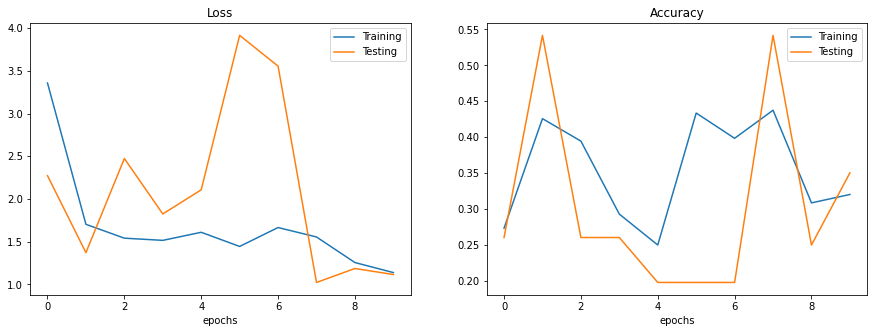

In [39]:
loss = torch.tensor(results["train_loss"])
test_loss = torch.tensor(results["test_loss"])

accuracy = torch.tensor(results["train_acc"])
test_accuracy = torch.tensor(results["test_acc"])

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(results['epochs'], loss, label='Training')
plt.plot(results['epochs'], test_loss, label='Testing')
plt.title("Loss")
plt.xlabel('epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results['epochs'], accuracy, label='Training')
plt.plot(results['epochs'], test_accuracy, label='Testing')
plt.title("Accuracy")
plt.xlabel('epochs')
plt.legend();

#### Wow.. Intresting...
#### A *good* news and a *bad* news. 
**Good News:** Our model actually works. The one we made from almost scratch. It works! 

**Bad News:** But why isn't our model training well? ViT is meant to be competing with *state-of-the-art* models right?


### Trying out a **PreTrained ViT** model

In [40]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seed()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [41]:
# Applying the transformers recommened by the "pretrained" model
vit16_transforms = pretrained_vit_weights.transforms()

# Loading a new pair of dataloaders
new_train_dataloader, new_test_dataloader, class_names = data_setup.create_dataset(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit16_transforms)

In [42]:
from going_modular import engine

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3,
                             betas=(0.9, 0.999), weight_decay=0.1)
 
set_seed() # Sets random seed to "42"

pretrained_results = engine.train(pretrained_vit, 
                                  epochs=10,
                                  train_data=new_train_dataloader,
                                  test_data=new_test_dataloader,
                                  loss=loss_fn,
                                  optimizer=optimizer,
                                  device=device)

EPOCH [0]
Train Loss: 0.7663, Train Acc: 0.73% | Test Loss: 0.5434, Test Acc: 0.87% 
------------
EPOCH [1]
Train Loss: 0.3433, Train Acc: 0.95% | Test Loss: 0.3273, Test Acc: 0.90% 
------------
EPOCH [2]
Train Loss: 0.2076, Train Acc: 0.95% | Test Loss: 0.2726, Test Acc: 0.91% 
------------
EPOCH [3]
Train Loss: 0.1575, Train Acc: 0.96% | Test Loss: 0.2446, Test Acc: 0.91% 
------------
EPOCH [4]
Train Loss: 0.1270, Train Acc: 0.97% | Test Loss: 0.2305, Test Acc: 0.90% 
------------
EPOCH [5]
Train Loss: 0.1264, Train Acc: 0.98% | Test Loss: 0.2159, Test Acc: 0.93% 
------------
EPOCH [6]
Train Loss: 0.0985, Train Acc: 0.98% | Test Loss: 0.2407, Test Acc: 0.89% 
------------
EPOCH [7]
Train Loss: 0.0858, Train Acc: 0.98% | Test Loss: 0.2325, Test Acc: 0.88% 
------------
EPOCH [8]
Train Loss: 0.1180, Train Acc: 0.99% | Test Loss: 0.2095, Test Acc: 0.94% 
------------
EPOCH [9]
Train Loss: 0.0744, Train Acc: 0.99% | Test Loss: 0.1821, Test Acc: 0.92% 
------------


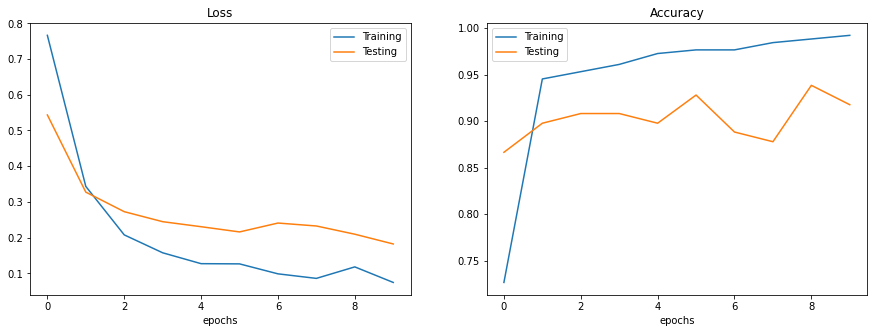

In [43]:
loss = torch.tensor(pretrained_results["train_loss"])
test_loss = torch.tensor(pretrained_results["test_loss"])

accuracy = torch.tensor(pretrained_results["train_acc"])
test_accuracy = torch.tensor(pretrained_results["test_acc"])

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(pretrained_results['epochs'], loss, label='Training')
plt.plot(pretrained_results['epochs'], test_loss, label='Testing')
plt.title("Loss")
plt.xlabel('epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(pretrained_results['epochs'], accuracy, label='Training')
plt.plot(pretrained_results['epochs'], test_accuracy, label='Testing')
plt.title("Accuracy")
plt.xlabel('epochs')
plt.legend();

In [44]:
y_preds = []

pretrained_vit.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_preds.append(torch.argmax(torch.softmax(pretrained_vit(X), dim=1), dim=1))

y_preds = torch.cat(y_preds)
len(y_preds)

75

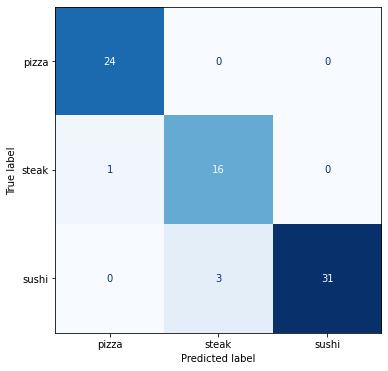

In [45]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import time
cm = confusion_matrix(y_preds.cpu(), new_test_dataloader.dataset.targets)

fig, ax = plt.subplots(figsize=(6, 6))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names)

cm_display.plot(cmap='Blues', colorbar=False, ax=ax, include_values=True)
plt.show()